# Estimating proton yields from nTOF measurements

Note: because of how ReadTheDocs works, this notebook is pre-executed

In [2]:
from cr39py.core.units import u
from cr39py.models.fusion import reactions, cross_section, reactivity, d3hep_yield, ddp_energy
import numpy as np
import matplotlib.pyplot as plt

Charged particles detected using CR39 are often generated by nuclear fusion reactions. The `cr39py.models.fusion` module contains nuclear reaction data (scraped from the ENDF database) for the following reactions

In [10]:
print(reactions)

['D(D,n)', 'D(D,p)', '3He(D,p)']


This includes cross-sections (reported in the center-of-mass frame of reference) and reactivities (averaged over a Maxwellian)

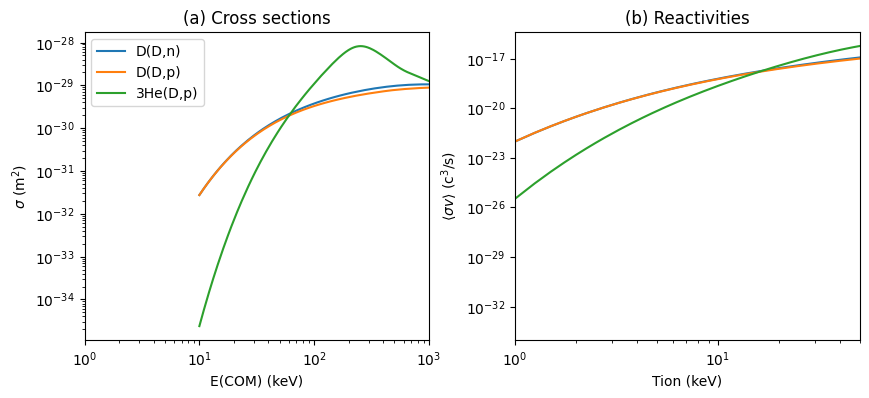

In [11]:
fig, axarr = plt.subplots(ncols=2, figsize=(10,4))
fig.subplots_adjust(wspace=0.25)
energies = np.logspace(1,3,500)*u.keV
tions = np.arange(0.25, 50, 0.25)*u.keV
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim(1,1e3)
axarr[0].set_title("(a) Cross sections")
axarr[0].set_xlabel("E(COM) (keV)")
axarr[0].set_ylabel("$\\sigma$ (m$^2$)")


axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlim(1,50)
axarr[1].set_title("(b) Reactivities")
axarr[1].set_xlabel("Tion (keV)")
axarr[1].set_ylabel("$\\langle \\sigma v \\rangle$ (c$^3$/s)")

for r in reactions:
    energies, xs = cross_section(r, energies=energies)
    axarr[0].plot(energies.m_as(u.keV), xs.m_as(u.m**2), label=r)

    react = reactivity(r, tions)
    axarr[1].plot(tions.m_as(u.keV), react.m_as(u.cm**3/u.s))


axarr[0].legend();

A common application for this data is determining the expected 3He(D,p) yield of an exploding pusher implosion (commonly used as a backlighter for proton radiography) based on the D(D,n) yield and ion temperature measure by neutron time-of-flight detectors. In this case, the proton yield is determined by the ratio of the reactivities at the average ion temperature and the relative prevelance of the D and 3He in the fuel (usually recorded as partial pressure). CR39py includes a function to neatly do this calculation for you for this specific case

In [12]:
D_pressure = 6.5*u.atm
He_pressure = 13*u.atm
DDn_yield = 1e8
Tion = 11 * u.keV
D3He_proton_yield = d3hep_yield(DDn_yield, D_pressure, He_pressure, Tion)
yield_ratio = D3He_proton_yield/DDn_yield
print(f"D3He Yield: {D3He_proton_yield:.2e}, Yield ratio: {yield_ratio:.2f}")

D3He Yield: 4.48e+07, Yield ratio: 0.45


## Compensating for capsule charging

Implosion targets are positively charged as electrons are ejected from the target surface. The resulting potential gives positive fusion products an upshift in energy that is variable from shot to shot.

However, since the birth energies of fusion products are known, the upshift can  be calculated by observing the final energy of a known product. For example, if the 14.7 MeV proton from D3He fusion is observed at 15.5 MeV, the upshift must be 0.8 MeV. Of course, this calculation assumes the potential experienced by all particles is the same, which is only true if particles are born at approximately the same time.

In many experiments on OMEGA, the D3He proton energy is measured, but the DD proton energy is not. So, cr39py includes the following function for calculating the DD proton energy, which is simply equivalent to the calculation $E_{DD} = E_{D3He, measured} - 14.64 + 3.02$

In [7]:
e_ddp = ddp_energy(15.5)
print(f" {e_ddp:.2f} MeV")

 3.88 MeV
